In [6]:
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

/fp/homes01/u01/ec-gerald/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [27]:
dag_data = "/fp/homes01/u01/ec-gerald/ec192/data/endo-radiographs/dag/clips"
deniz_data = "/fp/homes01/u01/ec-gerald/ec192/data/endo-radiographs/deniz/clips"
angel_data = "/fp/homes01/u01/ec-gerald/ec192/data/endo-radiographs/charlies/clips"
csv_file = 'codefile.csv'

data_dirs = [dag_data, deniz_data, angel_data]
#data_dirs = [deniz_data]
csv_files = [csv_file]*3

Define a custom dataset class that loads images and labels:

In [8]:
## Lets data from more than one locationg be loaded:
class CustomDataset(Dataset):
    def __init__(self, data_dirs, csv_files, transform=None):
        self.data_info = pd.DataFrame()
        self.data_dirs = data_dirs
        for i, (data_dir, csv_file) in enumerate(zip(data_dirs, csv_files)):
            full_csv_path = os.path.join(data_dir, csv_file)
            temp_df = pd.read_csv(full_csv_path)
            temp_df['data_dir'] = data_dir  # Add a column to store the corresponding directory
            self.data_info = pd.concat([self.data_info, temp_df])
        self.transform = transform

    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        data_dir = self.data_info.iloc[idx]['data_dir']
        img_name = os.path.join(data_dir, self.data_info.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Load as grayscale
        
        # Convert to numpy array and stack to create a 3-channel image
        image_np = np.array(image)
        image_np = np.stack([image_np]*3, axis=2)
        
        # Convert back to PIL Image
        image = Image.fromarray(image_np, 'RGB')

        label = int(self.data_info.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


Define data transformations. Since your images are 8-bit grayscale, you can normalize them to the range [0, 1]:

In [35]:
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomRotation(5),         # Rotate randomly up to 5 degrees
    transforms.RandomResizedCrop(256, scale=(0.95, 1.0)),  # Slight zoom
    transforms.RandomHorizontalFlip(),    # Horizontal flip with 50% probability
    transforms.Resize((256, 256)),  # Resize all images to the same size
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Normalize
])


In [36]:
custom_dataset = CustomDataset(data_dirs=data_dirs, csv_files=csv_files, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(custom_dataset, test_size=0.2, random_state=42)

# Create data loaders for training and validation
batch_size = 64  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
from collections import defaultdict

# Initialize a dictionary to store class counts
class_counts = defaultdict(int)

# Iterate through the custom dataset and count class occurrences
for _, label in custom_dataset:
    class_counts[label] += 1

# Calculate the total number of samples
total_samples = len(custom_dataset)

# Calculate the percentage of each class
class_percentages = {label: count / total_samples * 100 for label, count in class_counts.items()}

# Create a Pandas DataFrame to display the statistics
statistics_df = pd.DataFrame({'Class': class_counts.keys(), 'Count': class_counts.values(), 'Percentage (%)': class_percentages.values()})

# Display the table in Jupyter Notebook
statistics_df

,Class,Count,Percentage (%)
0,3,763,41.422367
1,4,167,9.066232
2,1,576,31.270358
3,2,290,15.743757
4,5,46,2.497286


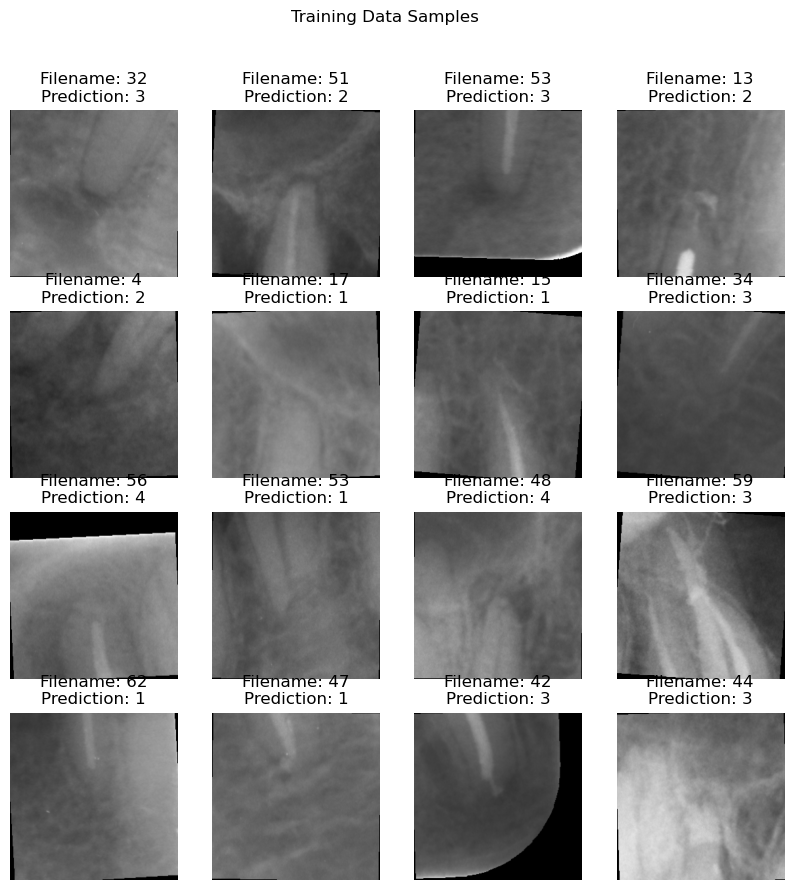

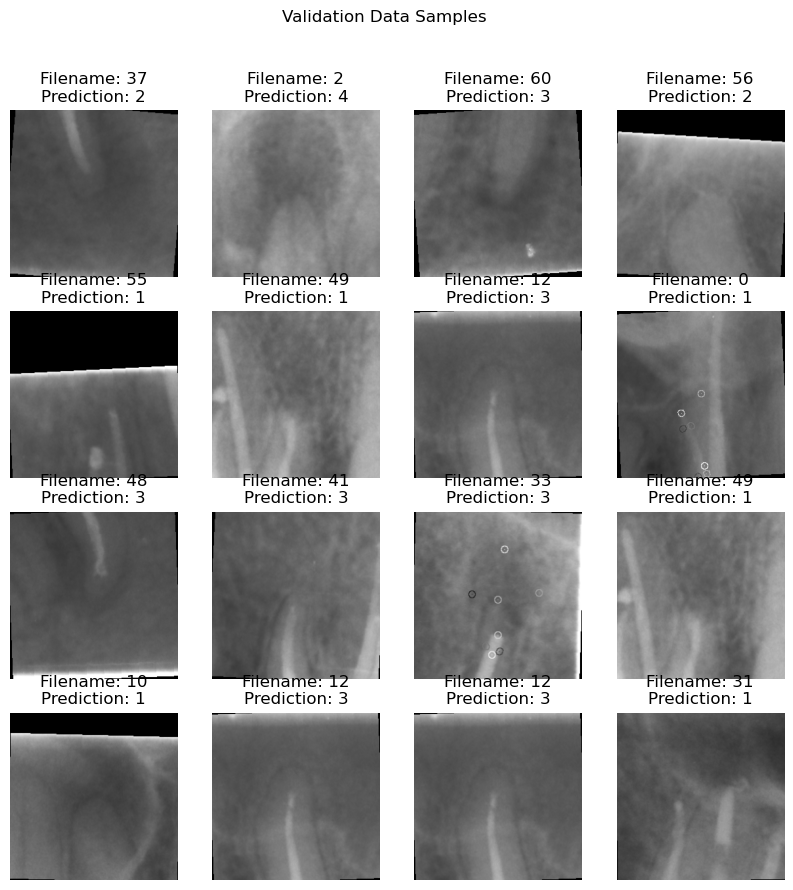

In [25]:
# Visualize some of the data
import random

# Function to visualize 4x4 grid of images
def visualize_images(dataloader, title):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    for i in range(16):  # You can adjust this for a different grid size
        plt.subplot(4, 4, i+1)
        for images, labels in dataloader:
            img_idx = random.randint(0, images.shape[0] - 1)
            
            # Convert to numpy and transpose to fit matplotlib's channel order
            img = images[img_idx].numpy().transpose((1, 2, 0))
            
            # Inverse normalization (if you used normalization in transformations)
            img = img * np.array([1.0, 1.0, 1.0]) + np.array([0.0, 0.0, 0.0])
            
            plt.title(f"Filename: {img_idx}\nPrediction: {labels[img_idx]}")
            plt.imshow(img)
            plt.axis('off')
            
            break  # We break as we just need one batch of images
    plt.show()

# Visualize random images from train_loader and val_loader
visualize_images(train_loader, "Training Data Samples")
visualize_images(val_loader, "Validation Data Samples")


# Running the model
This function is used to run the model. Several hyperparameters are adjusted with variables.
Results of the training process is shown in a graph

In [18]:
learning_rate = 0.001

def runTraining(model, num_epochs=10):
    %matplotlib inline
    # Check if CUDA is available and move the model to the GPU if so
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Calculate class weights
    class_weights = [total_samples / (count * len(class_counts)) for count in class_counts.values()]
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)  # Move to GPU if available

    # Initialize the model, loss function, and optimizer
    model = model
    criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use class weights here
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define number of epochs
    num_epochs = num_epochs

    model.to(device)

    # Lists to store training and validation losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            # Map labels to the expected range (0-4)
            labels = labels - 1
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Calculate validation loss and accuracy after each epoch
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_outputs = model(val_inputs)
                
                # Map validation labels to the expected range (0-4)
                val_labels = val_labels - 1
                
                val_loss += criterion(val_outputs, val_labels).item()
                
                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Print training and validation loss and accuracy
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]}, Training Accuracy: {train_accuracies[-1]}%, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}%")

        model.train()  # Set the model back to training mode

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


    print("Training finished.")